# SE-ResNet50 on SkyView Dataset (Kaggle, with 80/20 Split, Full Classes)

In [2]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Path to dataset (Kaggle version)
dataset_path = '/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes'

# Load all images from each class, report unreadable images
def load_and_split_by_class(dataset_path, image_size=(224, 224), train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []

    for label in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        files = sorted(os.listdir(class_dir))
        images = []
        failed = 0
        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is None:
                failed += 1
                continue
            img = cv2.resize(img, image_size)
            images.append(img)

        print(f"Class '{label}': {len(images)} images loaded, {failed} failed")
        images = shuffle(images, random_state=42)
        split_idx = int(len(images) * train_ratio)
        X_train.extend(images[:split_idx])
        y_train.extend([label] * split_idx)
        X_test.extend(images[split_idx:])
        y_test.extend([label] * (len(images) - split_idx))

    return shuffle(np.array(X_train), np.array(y_train), random_state=42), shuffle(np.array(X_test), np.array(y_test), random_state=42)

(X_train, y_train), (X_test, y_test) = load_and_split_by_class(dataset_path)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))
class_names = le.classes_.tolist()

print("Each class split 80/20 successfully. Classes:", class_names)


2025-04-18 07:29:54.954279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744961395.149129      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744961395.203925      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class 'Agriculture': 800 images loaded, 0 failed
Class 'Airport': 800 images loaded, 0 failed
Class 'Beach': 800 images loaded, 0 failed
Class 'City': 800 images loaded, 0 failed
Class 'Desert': 800 images loaded, 0 failed
Class 'Forest': 800 images loaded, 0 failed
Class 'Grassland': 800 images loaded, 0 failed
Class 'Highway': 800 images loaded, 0 failed
Class 'Lake': 800 images loaded, 0 failed
Class 'Mountain': 800 images loaded, 0 failed
Class 'Parking': 800 images loaded, 0 failed
Class 'Port': 800 images loaded, 0 failed
Class 'Railway': 800 images loaded, 0 failed
Class 'Residential': 800 images loaded, 0 failed
Class 'River': 800 images loaded, 0 failed
Each class split 80/20 successfully. Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data_generators(use_augmentation):
    if use_augmentation:
        train_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    else:
        train_gen = ImageDataGenerator(rescale=1./255)
    test_gen = ImageDataGenerator(rescale=1./255)
    return (
        train_gen.flow(X_train, y_train_enc, batch_size=32),
        test_gen.flow(X_test, y_test_enc, batch_size=32, shuffle=False)
    )


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply, Reshape

def build_model(use_se=True, fine_tune=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    if use_se:
        # SE block definition
        channels = x.shape[-1]
        se = GlobalAveragePooling2D()(x)
        se = Reshape((1, 1, channels))(se)
        se = Dense(channels // 16, activation='relu')(se)
        se = Dense(channels, activation='sigmoid')(se)
        x = Multiply()([x, se])
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(y_train_enc.shape[1], activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    for layer in base_model.layers:
        layer.trainable = fine_tune
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
configs = [
    {"name": "A_baseline", "use_se": False, "fine_tune": False, "aug": False},
    {"name": "B_se_finetune", "use_se": True, "fine_tune": True, "aug": False},
    {"name": "C_final", "use_se": True, "fine_tune": True, "aug": True},
]

results = {}
sample_predictions = {}

for cfg in configs:
    print(f"Training {cfg['name']}...")
    model = build_model(use_se=cfg["use_se"], fine_tune=cfg["fine_tune"])
    train_data, test_data = get_data_generators(use_augmentation=cfg["aug"])
    history = model.fit(train_data, validation_data=test_data, epochs=5, verbose=0)
    eval_acc = model.evaluate(test_data, verbose=0)[1]
    results[cfg['name']] = round(eval_acc * 100, 2)
    y_probs = model.predict(test_data)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test_enc, axis=1)
    sample_predictions[cfg['name']] = (y_true, y_pred)
    print(f"{cfg['name']} Accuracy: {results[cfg['name']]}%\n")


Training A_baseline...


I0000 00:00:1744961547.825730      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744961561.818503      91 service.cc:148] XLA service 0x78c2b4002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744961561.819317      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744961563.088058      91 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744961567.455288      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
A_baseline Accuracy: 23.17%

Training B_se_finetune...
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
B_se_finetune Accuracy: 78.54%

Training C_final...
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step
C_final Accuracy: 70.96%



,Experiment,Accuracy (%),Precision,Recall,F1-score
1,B_se_finetune,78.54,0.832,0.785,0.790
2,C_final,70.96,0.788,0.710,0.703
0,A_baseline,23.17,0.176,0.232,0.179


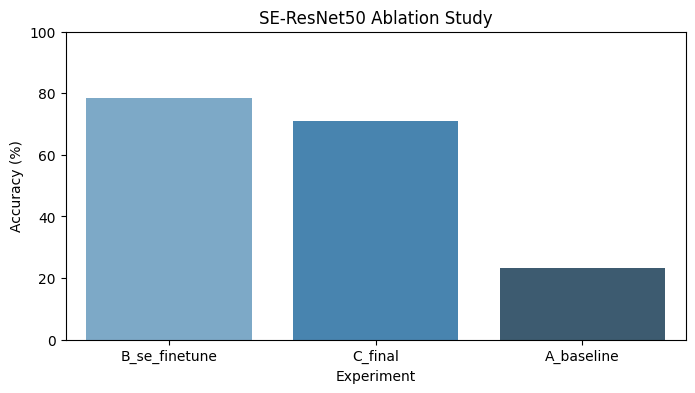

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics = []

for model_name, (y_true, y_pred) in sample_predictions.items():
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    avg = report['weighted avg']
    metrics.append({
        'Experiment': model_name,
        'Accuracy (%)': round(report['accuracy'] * 100, 2),
        'Precision': round(avg['precision'], 3),
        'Recall': round(avg['recall'], 3),
        'F1-score': round(avg['f1-score'], 3)
    })

ablation_df = pd.DataFrame(metrics)
ablation_df = ablation_df.sort_values("Accuracy (%)", ascending=False)
display(ablation_df)

plt.figure(figsize=(8, 4))
sns.barplot(data=ablation_df, x="Experiment", y="Accuracy (%)", palette="Blues_d")
plt.title("SE-ResNet50 Ablation Study")
plt.ylim(0, 100)
plt.show()


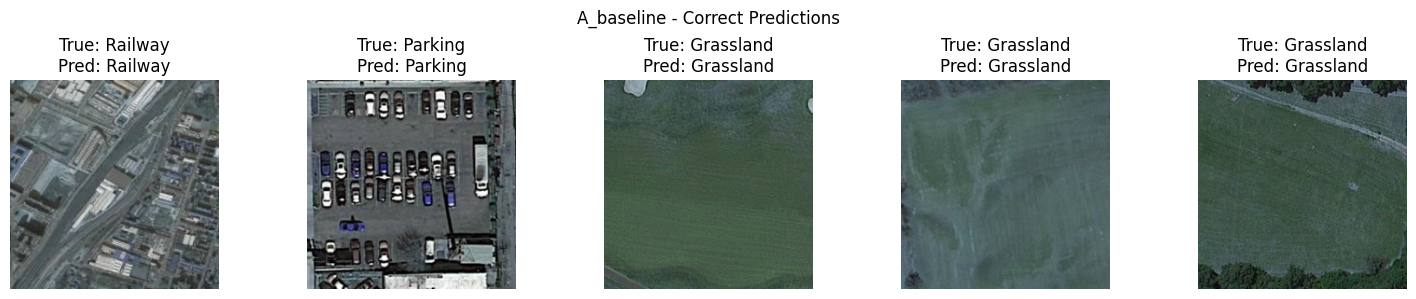

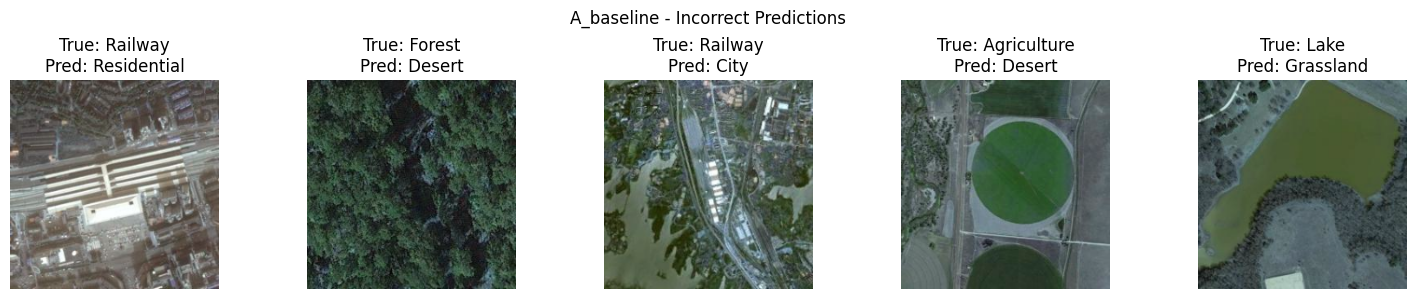

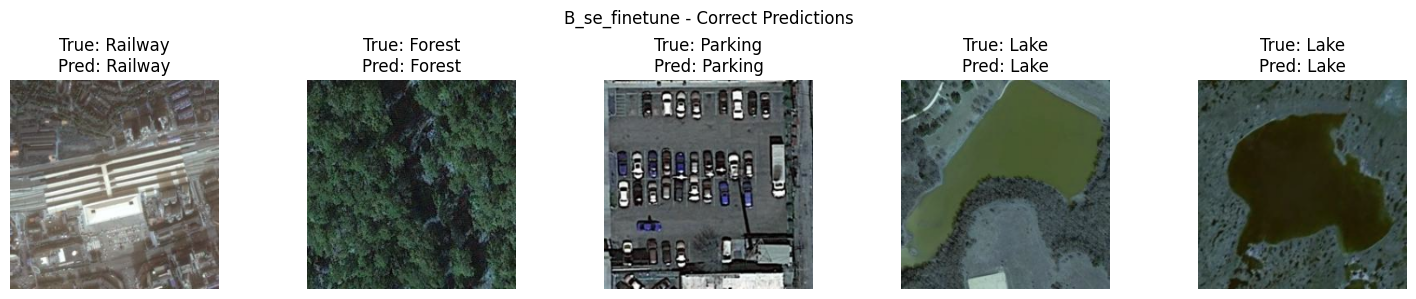

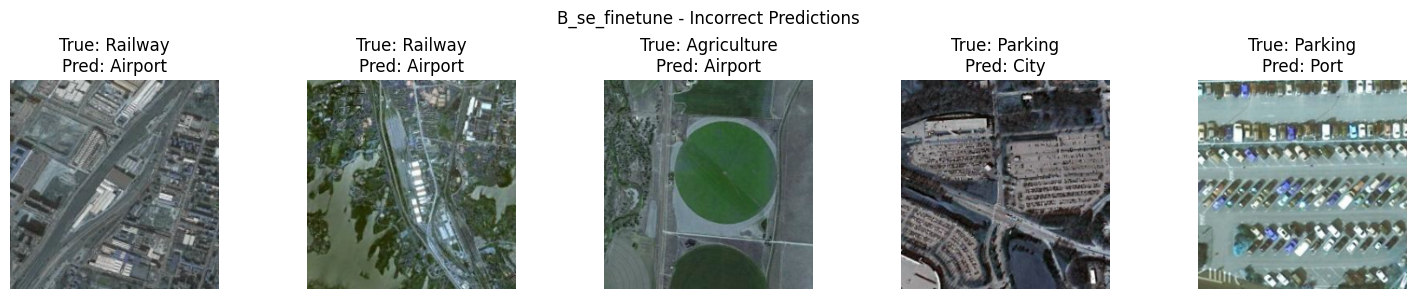

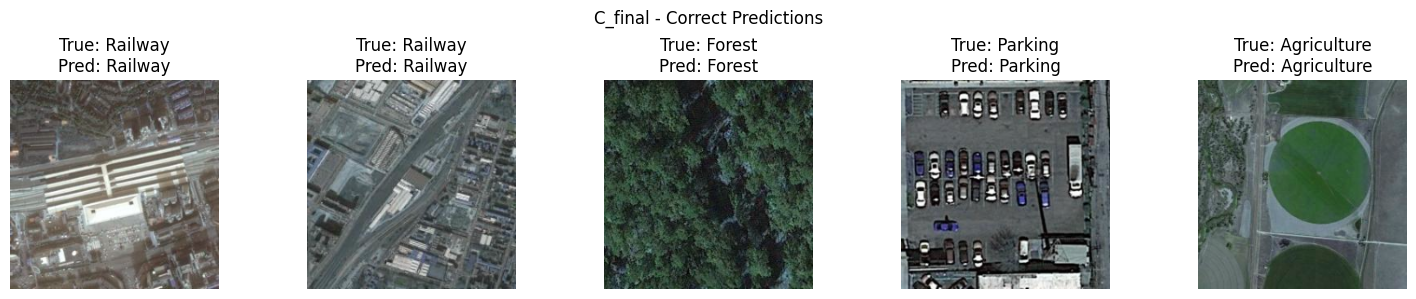

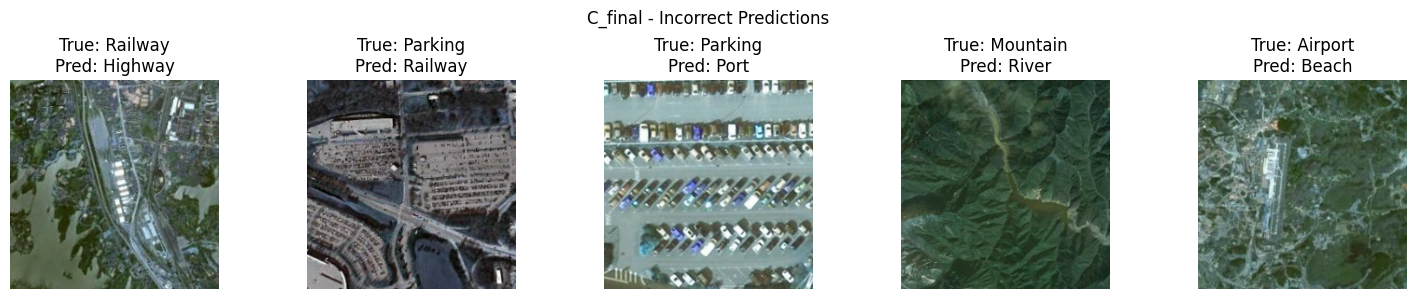

In [7]:
import matplotlib.pyplot as plt

def plot_sample_predictions(name, y_true, y_pred, X=X_test, class_names=class_names, max_samples=5):
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]

    def plot_group(indices, title):
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices[:max_samples]):
            img = X[idx]
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            plt.subplot(1, max_samples, i + 1)
            plt.imshow(img.astype('uint8'))
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
        plt.suptitle(f"{name} - {title}")
        plt.tight_layout()
        plt.show()

    plot_group(correct_idx, "Correct Predictions")
    plot_group(incorrect_idx, "Incorrect Predictions")

for model_name, (y_true, y_pred) in sample_predictions.items():
    plot_sample_predictions(model_name, y_true, y_pred)
